In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set(context='notebook', font_scale=1.2, rc={'figure.figsize': (12, 5)})
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

RANDOM_SEED = 8927
np.random.seed(286)

# Helper function
def stdz(series: pd.Series):
    """Standardize the given pandas Series"""
    return (series - series.mean())/series.std()

### 11E1.
*What is the difference between an ordered categorical variable and an unordered one? Define and then give an example of each.*

- *Unordered categorical variable*: a variable that has distinct and discrete outcomes, which do not present any particular order. For example, imagine that you record customers' choice of crêpes on the *Pont des Arts* in Paris. Your outcome variable could have four distinct categories - sugar, marmelade, salted caramel and, of course, Nutella - but these categories do not have inherent ordering (though who would choose sugar when you can have Nutella??). These variables are the natural extension of binary outcomes to more than two categories. Other examples include choices among colors, individual identities, and individual words.

- *Ordered categorical variable*: a variable that has distinct and discrete outcomes, which have an inherent order. There your outcome variable could be the scale on which you like Nutella on your crêpe - 1 to 10 for example. Note that the distances between the values are not necessarily the same. So for example the amount of change required to move a value from 1 to 2 may be different from the amount of change required to move from 2 to 3. Other examples include subjective ratings, “Likert” scales, and relative distances or durations.

### 11E2.
*What kind of link function does an ordered logistic regression employ? How does it differ from an ordinary logit link?*

The conventional link is the cumulative logit link function. The cumulative probability of a value is the probability of that value or any smaller value. In simple logistic regressions, the linear model is defined on the log-odds scale. In *ordered* logistic regression, the linear model is defined on the log-cumulative-odds scale.

### 11E3.
*When count data are zero-inflated, using a model that ignores zero-inflation will tend to induce which kind of inferential error?*

Ignoring zero-inflation will tend to underestimate the rate of events. Why? Because a count distribution with extra zeros added to it will have a lower mean. So treating such data as single-process count data will result in a lower estimate for the mean rate.

### 11E4.
*Over-dispersion is common in count data. Give an example of a natural process that might produce over-dispersed counts. Can you also give an example of a process that might produce under-dispersed counts?*

Over-dispersion can arise simply from variation in underlying rates across units. For example, if we count the number of ice creams sold by various ice cream shops for each day over an entire month, the aggregated counts will likely be over-dispersed. This is because some shops sell more ice cream than others — they do not all have the same average rate of sales across days.

Under-dispersion is considered less often. Under-dispersed count data has less variation than expected. One common process that might produce under-dispersed counts is when sequential observations are directly correlated with one another (autocorrelation). This is the premise of Conway-Maxwell-Poisson (aka COM-Poisson) distributions, which arise from one model of this kind, the state-dependent queuing model, commonplace in the study of servers and production systems of many kinds. Simply stated, when the rate at which jobs are completed depends upon how many jobs are waiting to be completed, then counts may be highly autocorrelated. This reduces variation in the observed counts, resulting in under-dispersion.

### 11M1.
*At a certain university, employees are annually rated from 1 to 4 on their productivity, with 1 being least productive and 4 most productive. In a certain department at this certain university in a certain year, the number of employees receiving each rating were (from 1 to 4): 12, 36, 7, 41. Compute the log-cumulative-odds of each rating.*

In [2]:
hist = pd.DataFrame(index=[1, 2, 3, 4], columns=["counts"], data=[12, 36, 7, 41])
hist.index.name = "rating"

# proportion of each rating
props = hist / hist.sum()

# cumulative proportions of ratings
cum_props = props.cumsum()

# turn into odds and take the log, thanks to logit (hence cumulative logit)
sp.special.logit(cum_props)

,counts
rating,
1,-1.945910
2,0.000000
3,0.293761
4,inf


### 11M2.
*Make a version of figure 11.2 for the employee ratings data given just above.*

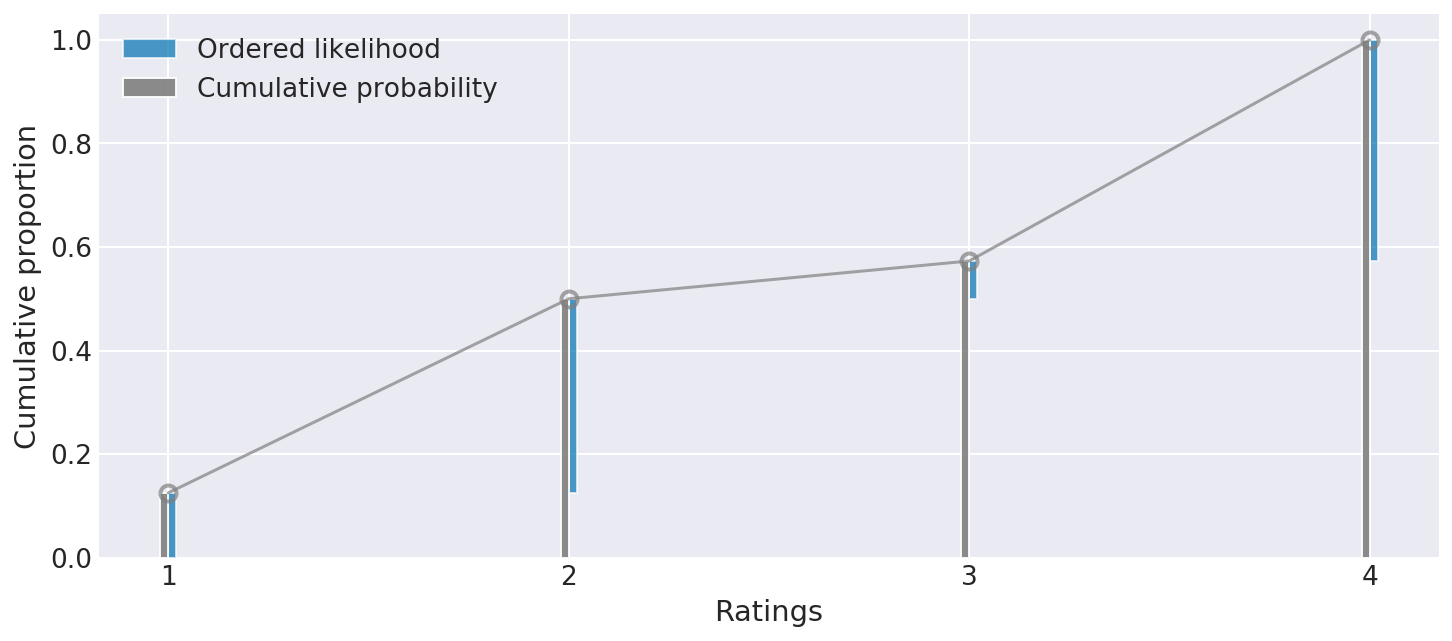

In [17]:
plt.figure(figsize=(12,5))
plt.bar(cum_props.index + .01, props.counts, bottom=pd.Series(0).append(cum_props.counts.iloc[:-1]), 
        width=.02, alpha=.7, label="Ordered likelihood")
plt.bar(cum_props.index - .01, cum_props.counts, width=.02, color="gray", alpha=.9, label="Cumulative probability")
plt.plot(cum_props.index, cum_props.counts, "-o", fillstyle="none", ms=8, markeredgewidth=2, color="gray", alpha=.7, label="")
plt.xticks(cum_props.index)
plt.xlabel("Ratings")
plt.ylabel("Cumulative proportion")
plt.legend();

### 11M3.
*Can you modify the derivation of the zero-inflated Poisson distribution (ZIPoisson) from the chapter to construct a zero-inflated binomial distribution?*

As with the zero-inflated Poisson, the zero-inflated binomial mixes some extra zeros into another distribution. The structure is very much the same as the ZIPoisson. First, a single probability determines whether or not a zero is observed. Call this probability $p_{0}$. When a zero is not observed from this first process, the binomial distribution takes over. It may also generate a zero. Call the probability of a success from the binomial process $q$, and let it have n trials. Then the probability of a zero, mixing together both processes, is:

$Pr(0|p_{0}, q, n) = p_{0} + (1 - p_{0})(1 - q)^n$

The logic is that either we get a zero from the first process, $p_{0}$ of the time, or we get a zero from the binomial, which happens only when all trials fail, $(1 − q)^n$ of the time. The probability of any particular non-zero observation $y$ is similarly:

$Pr(y|p_{0}, q, n) = (1 - p_{0})\frac{n!}{y!(n-y)!}q^y(1 - q)^{n-y}$

Compare this expression to the ZIPoisson expression in the chapter.

### 11H1.
*In 2014, a paper was published that was entitled "Female hurricanes are deadlier than male hurricanes". As the title suggests, the paper claimed that hurricanes with female names have caused greater loss of life, and the explanation given is that people unconsciously rate female hurricanes as less dangerous and so are less likely to evacuate.*

*Statisticians severly critized the paper after publication. Here, you'll explore the complete data used in the paper and consider the hypothesis that hurricanes with female names are deadlier.*

In [6]:
hurricanes = pd.read_csv("../Data/hurricanes.csv", sep=";")
# Standardize predictor, as usual
hurricanes["femininity"] = stdz(hurricanes.femininity)
hurricanes.tail()

,name,year,deaths,category,min_pressure,damage_norm,female,femininity
87,Gustav,2008,52,2,954,4360,0,-1.567471
88,Ike,2008,84,2,950,20370,0,-1.515826
89,Irene,2011,41,1,952,7110,1,0.773725
90,Isaac,2012,5,1,966,24000,0,-1.498613
91,Sandy,2012,159,2,942,75000,1,0.687651


In [3]:
hurricanes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 8 columns):
name            92 non-null object
year            92 non-null int64
deaths          92 non-null int64
category        92 non-null int64
min_pressure    92 non-null int64
damage_norm     92 non-null int64
female          92 non-null int64
femininity      92 non-null float64
dtypes: float64(1), int64(6), object(1)
memory usage: 5.8+ KB


*In this problem, you'll focus on predicting deaths using feminity of each hurricane's name. Fit and interpret the simplest possible model: a Poisson model of deaths using femininity as a predictor.*

*Compare the model to an intercept-only Poisson model of deaths. How strong is the association between femininity of name and deaths? Which storms does the model fit (retrodict) well? Which storms does it fir poorly?*

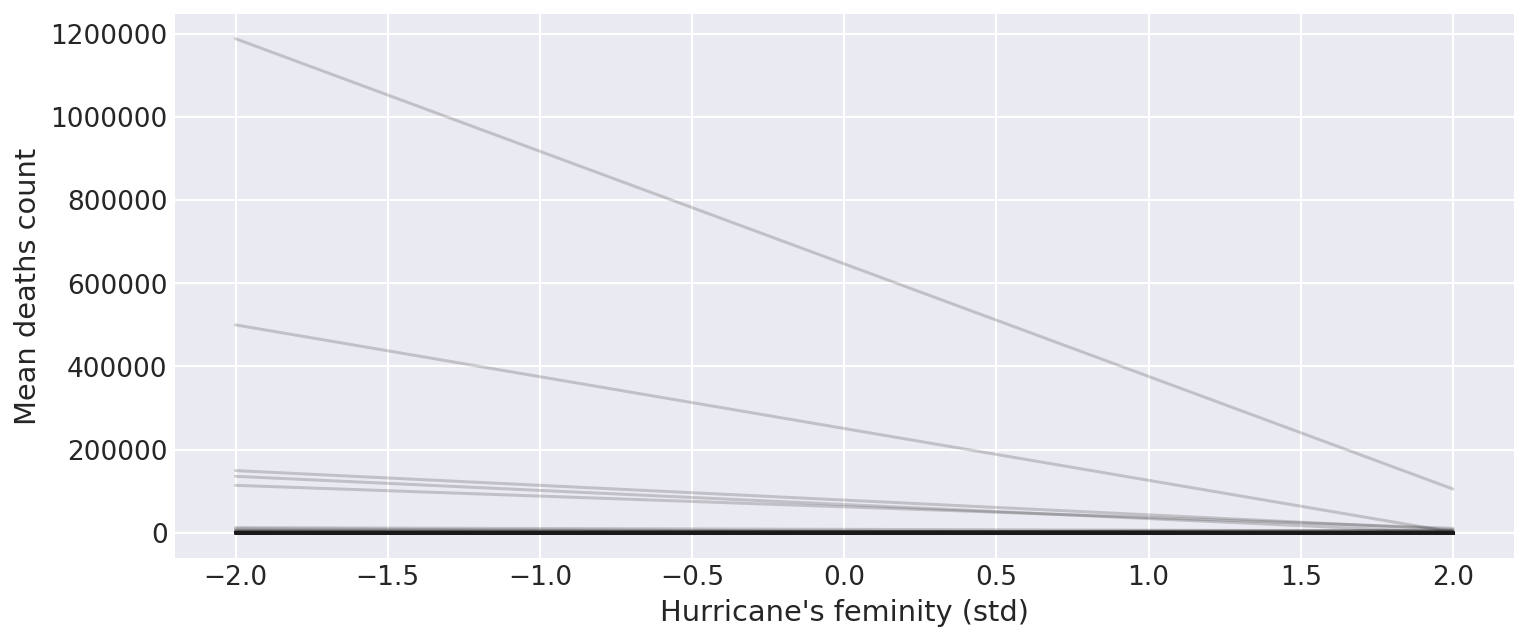

In [4]:
# Prior predictive checks, to see if prior choice makes sense
a_s = pm.Normal.dist(mu=0., sd=4.5).random(size=200)
bf_s = pm.Normal.dist(mu=0., sd=.8).random(size=200)

plt.figure(figsize=(12,5))
for y_s in zip(np.exp(a_s - 2*bf_s), np.exp(a_s + 2*bf_s)):
    plt.plot([-2, 2], y_s, color='k', alpha=.2)
plt.xlabel("Hurricane's femininity (std)")
plt.ylabel("Mean deaths count");

In [7]:
with pm.Model() as model_femininity:
    # The exp link makes the lambda really big, really quickly, so need strongly regularizing priors:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    
    # Casting predictor to theano shared variable for out of sample predictions later
    femininity = pm.Data('femininity', hurricanes.femininity)
    lam = pm.math.exp(a + bf*femininity)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_femininity = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_fem = pm.trace_to_dataframe(trace_femininity)
pm.summary(trace_femininity, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:06<00:00, 962.52draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.00,0.02,0.0,2.96,3.04,1657.99,1.0
bf,0.24,0.03,0.0,0.20,0.28,1767.52,1.0


So this model seems to think there is a reliably positive association between femininity of the hurricanes names and deaths.

In [6]:
with pm.Model() as model_itcpt:
    a = pm.Normal('a', 0., 4.5)
    
    deaths = pm.Poisson('deaths', mu=pm.math.exp(a), observed=hurricanes.deaths)

    trace_itcpt = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_itcpt = pm.trace_to_dataframe(trace_itcpt)
pm.summary(trace_itcpt, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:07<00:00, 792.69draws/s]
The acceptance probability does not match the target. It is 0.8862156745233059, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.03,0.02,0.0,2.99,3.06,718.0,1.0


/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """


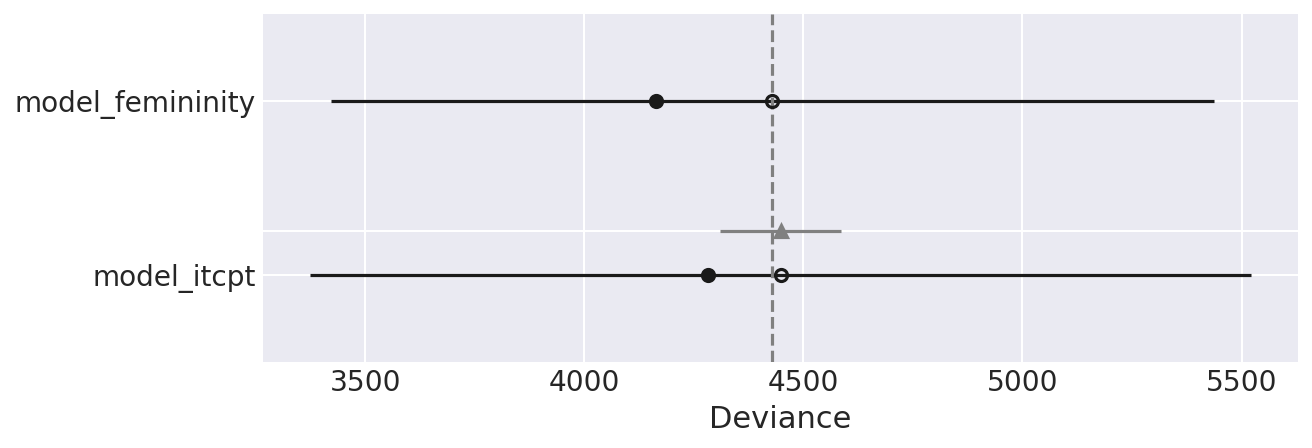

In [9]:
comp_df = az.compare({"model_itcpt": trace_itcpt, "model_femininity": trace_femininity})
az.plot_compare(comp_df, figsize=(9,3));

So the femininity model does not look to perform better out-of-sample than the incercept-only model: the difference in WAIC is quite low and, more importantly, is dwarfed by the standard error of that difference. Note that the standard error of both model is huge.

Now in order to see which hurricanes the model retrodicts well, we can plot the implied trend over the raw data points. We’ll compute and plot the expected death count, 89% interval of the expectation and 89% interval of the expected distribution of deaths (using Poisson sampling).

100%|██████████| 2000/2000 [00:08<00:00, 241.99it/s]


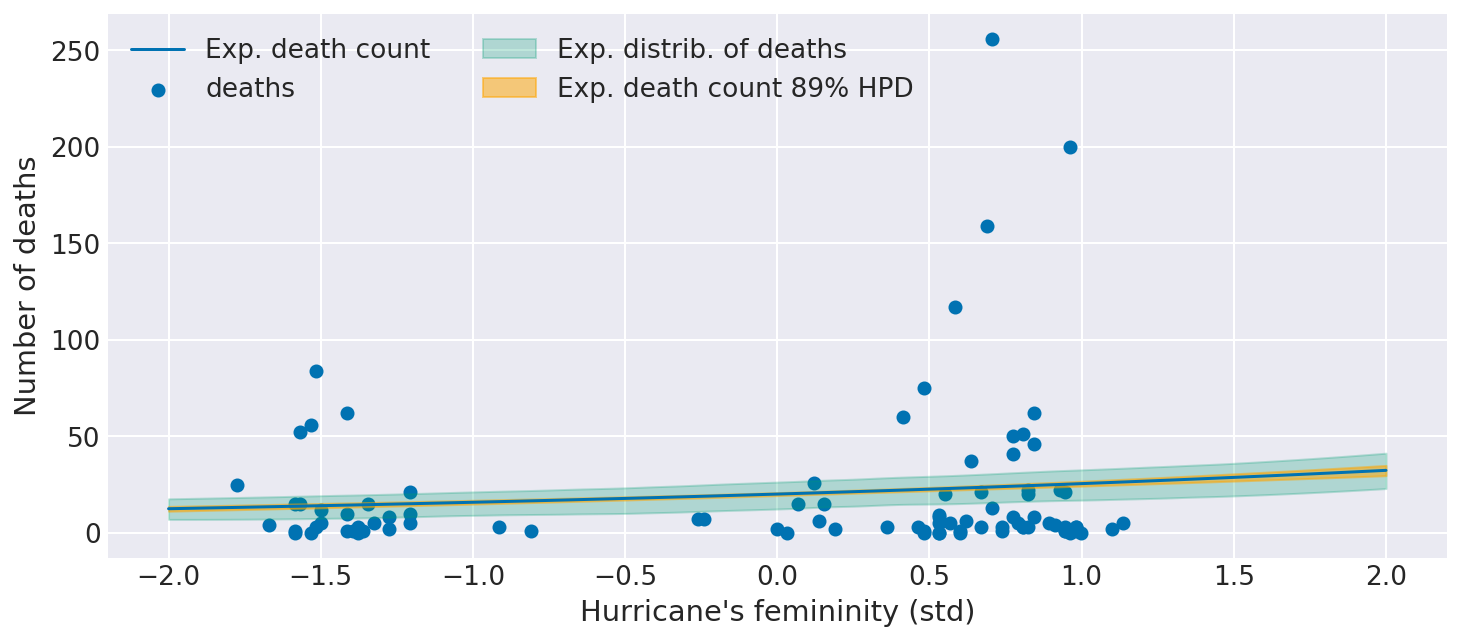

In [60]:
# define values to compute OOS predictions over
femininity_seq = np.linspace(-2, 2)

# lambda calcs
lambdas_post_pred = []
for fem in femininity_seq:
    lambdas_post_pred.append(np.exp(post_fem['a'] + post_fem['bf']*fem).values)
lambdas_post_pred = np.asarray(lambdas_post_pred).T

# outcome calcs
with model_femininity:
    pm.set_data({'femininity': femininity_seq})
    deaths_post_pred = pm.sample_posterior_predictive(trace_femininity, random_seed=RANDOM_SEED)['deaths']
    
# plot
plt.figure(figsize=(12,5))

plt.scatter(hurricanes.femininity, hurricanes.deaths)
az.plot_hpd(femininity_seq, deaths_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.25, "label": "Exp. distrib. of deaths"})
az.plot_hpd(femininity_seq, lambdas_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.5, "color": "orange", "label": "Exp. death count 89% HPD"})
plt.plot(femininity_seq, lambdas_post_pred.mean(axis=0), label="Exp. death count")

plt.xlabel("Hurricane's femininity (std)")
plt.ylabel("Number of deaths")
plt.legend(ncol=2);

We can hardly see the 89% interval of the expected value, because it is so narrow. The sampling distribution isn’t much wider itself. What you can see here is that femininity accounts for very little of the variation in deaths, especially at the high end. There’s a lot of over-dispersion, which is very common in Poisson models. As a consequence, this homogenous Poisson model does a poor job for most of the hurricanes in the sample, as most of them lie outside the prediction envelop (the green boundaries).

### 11H2.
*Counts are nearly always over-dispersed relative to Poisson. So fit a gamma-Poisson (aka negative-binomial) model to predict deaths using femininity. Show that the over-dispersed model no longer shows as precise a positive association between femininity and deaths, with an 89% interval that overlaps zero. Can you explain why the association diminished in strength?*

In [2]:
hurricanes = pd.read_csv("../Data/hurricanes.csv", sep=";")
hurricanes["femininity"] = stdz(hurricanes.femininity)

with pm.Model() as model_gampois:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    femininity = pm.Data('femininity', hurricanes.femininity)
    lam = pm.math.exp(a + bf*femininity)
    
    scale = pm.Exponential('scale', 1.)
    
    deaths = pm.NegativeBinomial("deaths", mu=lam, alpha=scale, observed=hurricanes.deaths)

    trace_gampois = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_gampois = pm.trace_to_dataframe(trace_gampois)
pm.summary(trace_gampois, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:10<00:00, 555.87draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,3.02,0.17,0.0,2.76,3.28,2786.29,1.0
bf,0.21,0.16,0.0,-0.03,0.47,2276.50,1.0
scale,0.45,0.06,0.0,0.35,0.54,2249.49,1.0


The 89% interval for bf now overlaps zero, because it has more than 5 times the standard deviation as the analogous parameter in the first model. 

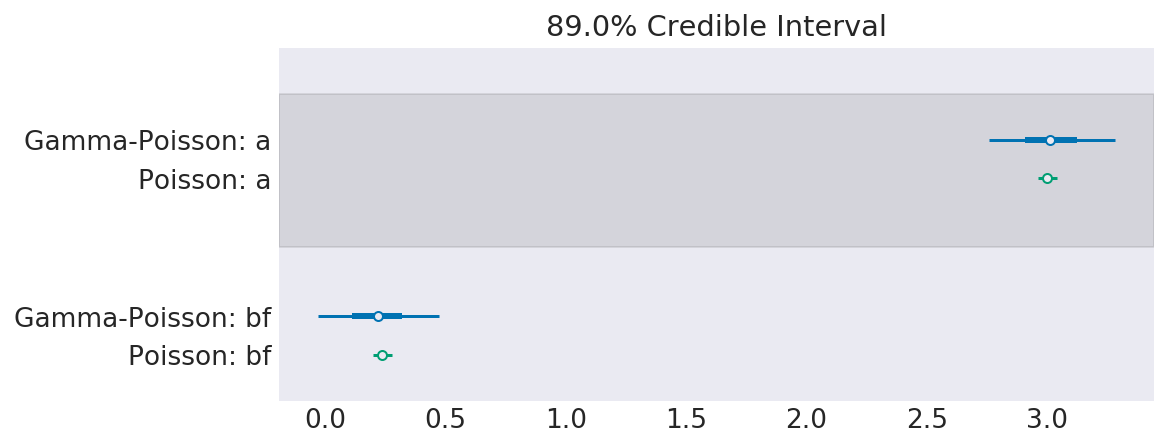

In [13]:
az.plot_forest([trace_gampois, trace_femininity], model_names=["Gamma-Poisson", "Poisson"], var_names=["a", "bf"],
               credible_interval=.89, figsize=(8,3), combined=True);

The Gamma-Poisson model has nearly the same posterior means for the intercept and slope $b_{f}$, but much more uncertainty.
How does this translate into predictions? To find out, let’s do the posterior-predictive checks we did earlier:

100%|██████████| 2000/2000 [00:09<00:00, 201.18it/s]


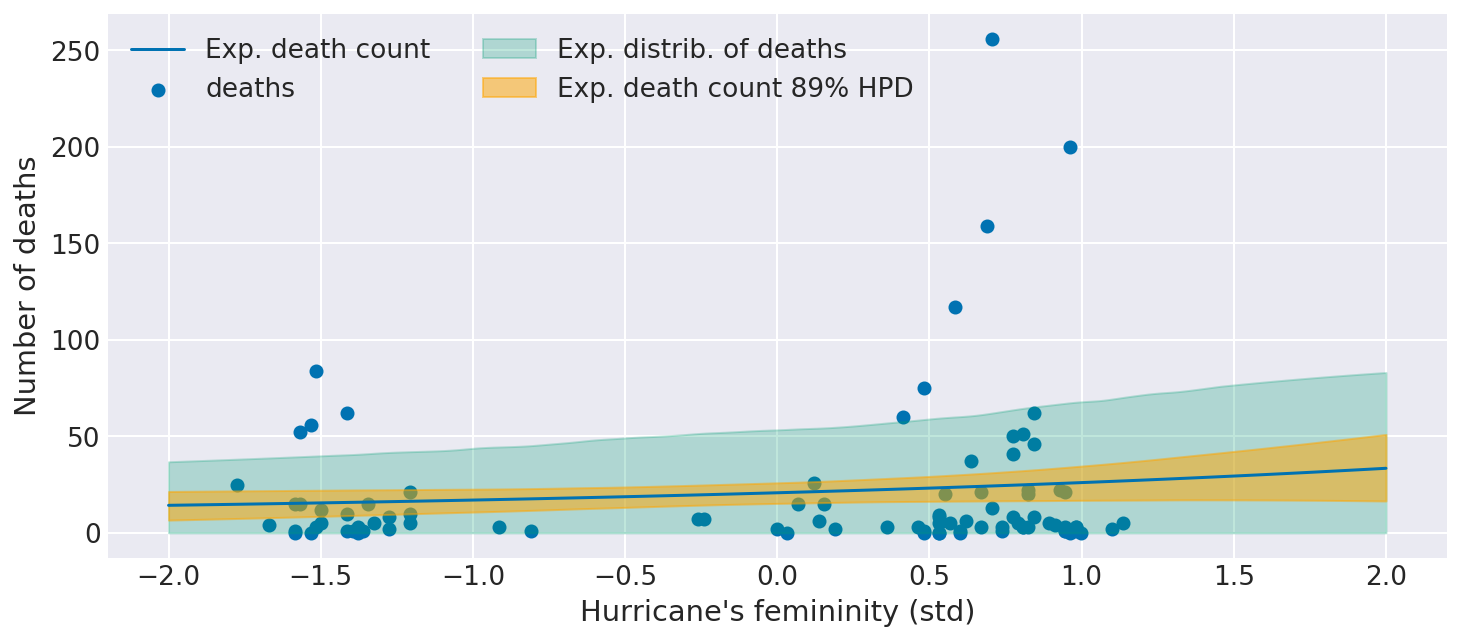

In [19]:
# define values to compute OOS predictions over
femininity_seq = np.linspace(-2, 2)

# lambda calcs
lambdas_post_pred = []
for fem in femininity_seq:
    lambdas_post_pred.append(np.exp(post_gampois['a'] + post_gampois['bf']*fem).values)
lambdas_post_pred = np.asarray(lambdas_post_pred).T

# outcome calcs
with model_gampois:
    pm.set_data({'femininity': femininity_seq})
    deaths_post_pred = pm.sample_posterior_predictive(trace_gampois, random_seed=RANDOM_SEED)['deaths']
    
# plot
plt.figure(figsize=(12,5))

plt.scatter(hurricanes.femininity, hurricanes.deaths)
az.plot_hpd(femininity_seq, deaths_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.25, "label": "Exp. distrib. of deaths"})
az.plot_hpd(femininity_seq, lambdas_post_pred, credible_interval=0.89, 
            fill_kwargs={"alpha": 0.5, "color": "orange", "label": "Exp. death count 89% HPD"})
plt.plot(femininity_seq, lambdas_post_pred.mean(axis=0), label="Exp. death count")

plt.xlabel("Hurricane's femininity (std)")
plt.ylabel("Number of deaths")
plt.legend(ncol=2);

There is more uncertainty now about the relationship, and the prediction interval is wider. But the predictions still aren't that good.


Now for the conceptual part of this problem: Why does including varying rates, via the gamma distribution, results in greater uncertainty in the relationship? The gamma-Poisson model allows each hurricane to have its own unique expected death rate, sampled from a common distribution that is a function of the femininity of hurricane names. We can actually plot this distribution from the posterior distribution, for any given femininity value. We’ll produce three examples, plotting 100 randomly sampled gamma distributions of the rate of deaths for three different femininity values:

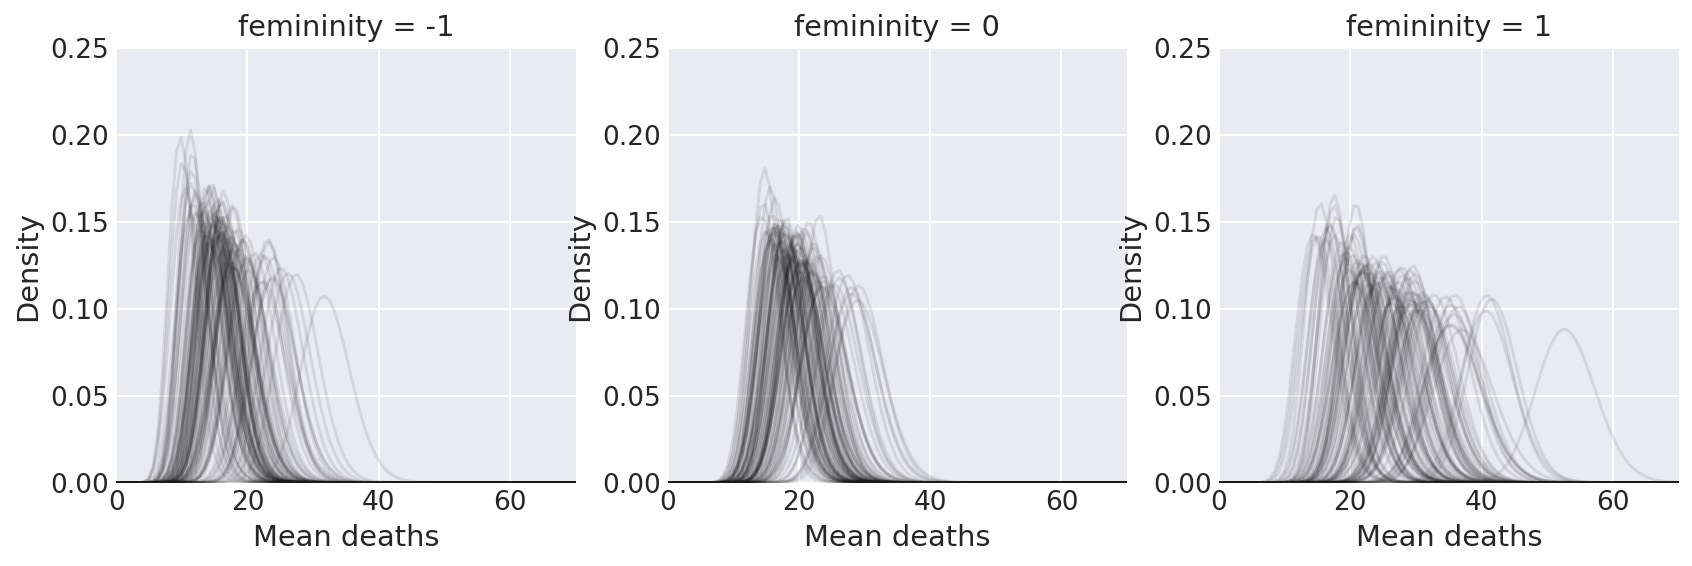

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for fem, ax in zip([-1, 0, 1], axes):
    x = np.linspace(0, 70, 100)
    samples = np.random.choice(len(post_gampois), size=100, replace=False)
    for i in samples:
        ax.plot(x, 
                sp.stats.gamma.pdf(x, 
                                   a=(np.exp(post_gampois["a"][i] + post_gampois["bf"][i]*fem) / post_gampois["scale"][i]),
                                   scale=post_gampois["scale"][i]),
                alpha=0.1, 
                color="k")
        # not sure about the gamma parametrization, as graph doesn't look exactly like Richard's solution
    ax.set_xlabel("Mean deaths")
    ax.set_xlim([0, 70])
    ax.set_ylabel("Density")
    ax.set_ylim([0, 0.25])
    ax.set_title(f"femininity = {fem}");

Each gray curve above is a gamma distribution of mean death rates, sampled from the posterior distribution of the model. This is an inherently confusing thing: a distribution sampled from a distribution. So let’s take it again, slowly. A gamma distribution is defined by two parameters: a mean and a scale. The mean in this model is controlled by the linear model and its two parameters, $a$ and $b_{f}$. The code above takes single values of $a$ and $b_{f}$ from the posterior distribution and builds a single linear model. It’s exponentiated in the code, because this model uses a log link. And the parameter $scale$ is the scale, so you can see that in the code as well. 

100 gamma distributions are drawn for each given value of femininity. This visualizes the uncertainty in the posterior about the variation in death rates. Read that again, slowly. It is a bit weird, but with a little time, it makes plenty of sense. Just like a simple parameter like an intercept has uncertainty, and the posterior distribution measures it (given a model and data), a function of parameters like a gamma distribution will also have uncertainty. Essentially, there are an infinite number of gamma distributions that are possible, the Bayesian model has considered all of them and ranked them by their plausibility. Each plot above shows 100 such gamma distributions, sampled from the posterior distribution in proportion to their plausibilities.

So now back to the explanation of why the parameters $a$ and $b_{f}$ have wider posterior distributions in this model. Once we allow any given values of $a$ and $b_{f}$ to produce many different death rates, because they feed into a gamma distribution that produces variation, then many more distinct values of $a$ and $b_{f}$ can be consistent with the data. This results in wider posterior distributions. The same phenomenon will reappear when we arrive at multilevel models in Chapter 12.

You might be curious how model_gampois compares to model_femininity in terms of WAIC. If so, take a look. You’ll find that the effective number of parameters for model_gampois is very very large. It does fit the data better. But it’s also very prone to overfitting. This is also a context in which DIC and WAIC very much disagree about model ranking. In my experience, Poisson models exhibit common disagreement between DIC and WAIC. Unlike DIC, WAIC is more data dependent. Exactly where the observations lie can make a big difference for WAIC but not for DIC. As a result, it is possible to get large disagreement between them, as in this example.

### 11H3.
*In order to infer a strong association between deaths and femininity, it's necessary to include an interaction effect. In the data, there are two measures of a hurricane's potential to cause death: damage_norm and min_pressure. It makes some sense to imagine that femininity of a name matters more when the hurricane is itself deadly. This implies an interaction between femininity and either or both of damage_norm and min_pressure. Fit a series of models evaluating these interactions. Interpret and compare the models. In interpreting the estimates, it may help to generate counterfactual predictions contrasting hurricanes with masculine and feminine names. Are the effect sizes plausible?*

In [6]:
hurricanes = pd.read_csv("../Data/hurricanes.csv", sep=";")
for col in ["femininity", "min_pressure", "damage_norm"]:
    hurricanes[f"{col}_std"] = stdz(hurricanes[col])

with pm.Model() as m_min_pressure_inter:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bp = pm.Normal('bp', 0., .8)
    bfp = pm.Normal('bfp', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity_std + bp*hurricanes.min_pressure_std + bfp*hurricanes.min_pressure_std*hurricanes.femininity_std)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_min_pressure_inter = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

# for comparison
with pm.Model() as m_min_pressure_nointer:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bp = pm.Normal('bp', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity_std + bp*hurricanes.min_pressure_std)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_min_pressure_nointer = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.compare({"m_min_pressure_inter": trace_min_pressure_inter, "m_min_pressure_nointer": trace_min_pressure_nointer})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bfp, bp, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:12<00:00, 466.01draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bp, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:11<00:00, 512.15draws/s]
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indic

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_min_pressure_nointer,3475.22,209.378,0,0.868337,1110.78,0,1,deviance
m_min_pressure_inter,3574.04,259.486,98.8236,0.131663,1147.41,55.6179,1,deviance


The model without the interaction seems to have a lot more support. Let’s also look at the interaction estimate itself:

In [3]:
pm.summary(trace_min_pressure_inter, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.72,0.03,0.0,2.68,2.77,1311.73,1.0
bf,0.26,0.03,0.0,0.21,0.31,1098.81,1.0
bp,-0.74,0.02,0.0,-0.78,-0.70,1241.33,1.0
bfp,0.07,0.03,0.0,0.03,0.11,991.09,1.0


The interaction coeffcient is positive. Interpreting this is a bit tricky, because hurricanes get stronger as their minimum pressure gets *lower*. So it makes sense for the main effect $b_{p}$ to be negative: storms with *larger* minimum pressure cause *fewer* deaths. Does it also make sense for the interaction to be positive? As usual, I advise caution with interpreting interactions from the coefficient table. Better to construct some counterfactual predictions and figure it out that way. Let’s do that and plot deaths against min_pressure, for both masculine and feminine storms:

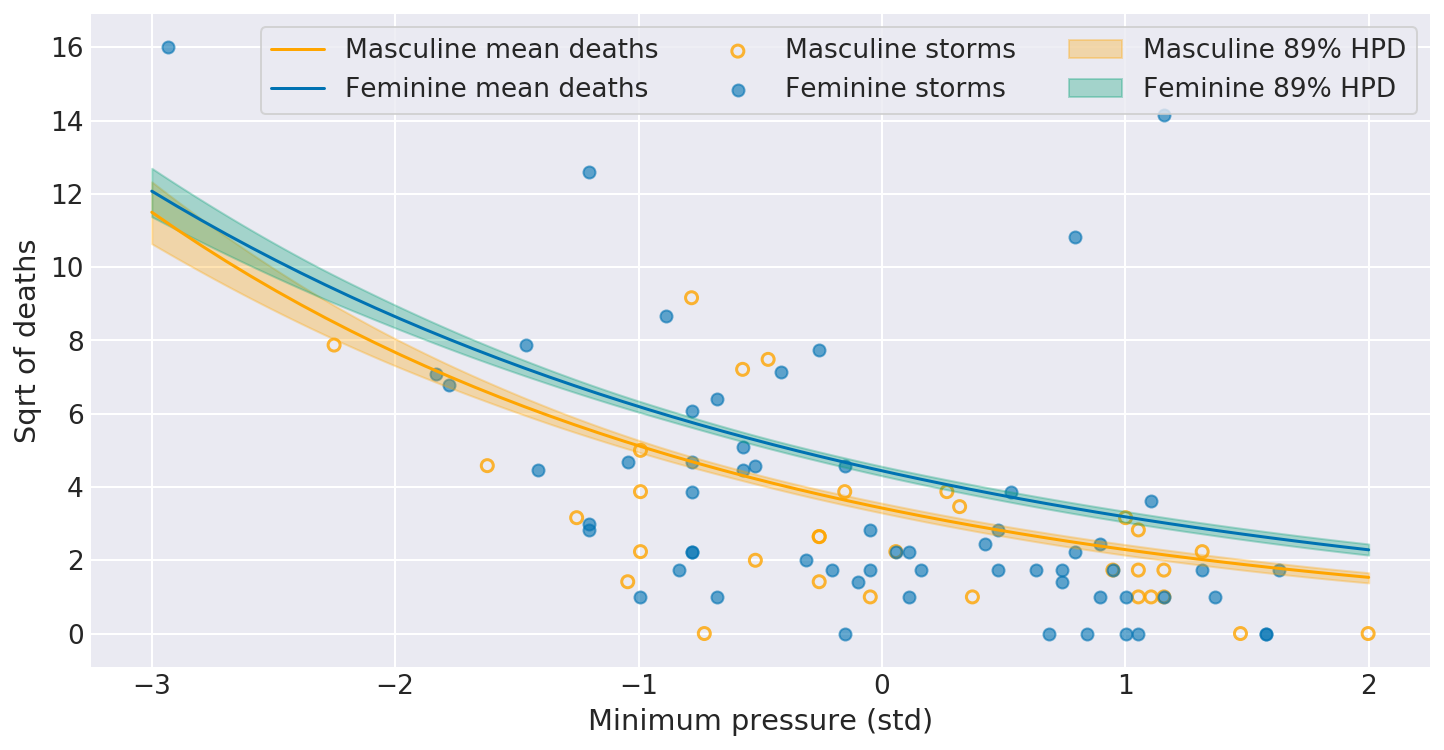

In [7]:
post_inter = pm.trace_to_dataframe(trace_min_pressure_inter)

# define values to compute OOS predictions over
minpress_seq = np.linspace(-3, 2)

# lambda calcs for masculine names (i.e femininity = -1)
l_post_pred_m = []
for minpress in minpress_seq:
    l_post_pred_m.append(np.exp(post_inter['a'] - post_inter['bf'] + post_inter['bp']*minpress - post_inter['bfp']*minpress).values)
l_post_pred_m = np.asarray(l_post_pred_m).T

# lambda calcs for feminine names (i.e femininity = 1)
l_post_pred_f = []
for minpress in minpress_seq:
    l_post_pred_f.append(np.exp(post_inter['a'] + post_inter['bf'] + post_inter['bp']*minpress + post_inter['bfp']*minpress).values)
l_post_pred_f = np.asarray(l_post_pred_f).T
    
# plot
# We use sqrt scale for deaths to make differences easier to see
# Cannot use log scale, bc of zeros in data
plt.figure(figsize=(12,6))
masc_storms = hurricanes[hurricanes.femininity_std < 0]
fem_storms = hurricanes[hurricanes.femininity_std >= 0]

plt.scatter(masc_storms.min_pressure_std, np.sqrt(masc_storms.deaths), label="Masculine storms", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)
plt.scatter(fem_storms.min_pressure_std, np.sqrt(fem_storms.deaths), label="Feminine storms", alpha=0.6)
az.plot_hpd(minpress_seq, np.sqrt(l_post_pred_m), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "color": "orange", "label": "Masculine 89% HPD"})
az.plot_hpd(minpress_seq, np.sqrt(l_post_pred_f), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "label": "Feminine 89% HPD"})
plt.plot(minpress_seq, np.sqrt(l_post_pred_m.mean(axis=0)), color="orange", label="Masculine mean deaths")
plt.plot(minpress_seq, np.sqrt(l_post_pred_f.mean(axis=0)), label="Feminine mean deaths")

plt.xlabel("Minimum pressure (std)")
plt.ylabel("Sqrt of deaths")
plt.legend(ncol=3, frameon=True);

The interaction model expects feminine storms to be a little more deadly, but the difference between masculine and feminine storms actually decreases as pressure drops - this is not in agreement with the hypothesis.

There’s another storm damage variable, however. Let’s repeat the above analysis, using damage_norm this time. The variable damage_norm is an estimate of the property damage of a storm. The notion is that this might serve as a proxy for potential to cause deaths, a better one than min_pressure because it may account for settlement patterns and population density. Here are the new models and their WAIC comparison:

In [8]:
with pm.Model() as m_damage_norm_inter:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    bfd = pm.Normal('bfd', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity_std + bd*hurricanes.damage_norm_std + bfd*hurricanes.damage_norm_std*hurricanes.femininity_std)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_damage_norm_inter = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

# for comparison
with pm.Model() as m_damage_norm_nointer:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity_std + bd*hurricanes.damage_norm_std)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_damage_norm_nointer = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.compare({"m_damage_norm_inter": trace_damage_norm_inter, "m_damage_norm_nointer": trace_damage_norm_nointer})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bfd, bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:13<00:00, 438.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:11<00:00, 397.84draws/s]
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indic

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_damage_norm_nointer,3207.11,124.765,0,0.594998,789.534,0,1,deviance
m_damage_norm_inter,3228.89,147.027,21.7838,0.405002,792.495,28.5985,1,deviance


Still not much support for the interaction. Let’s look at the counterfactual predictions again:

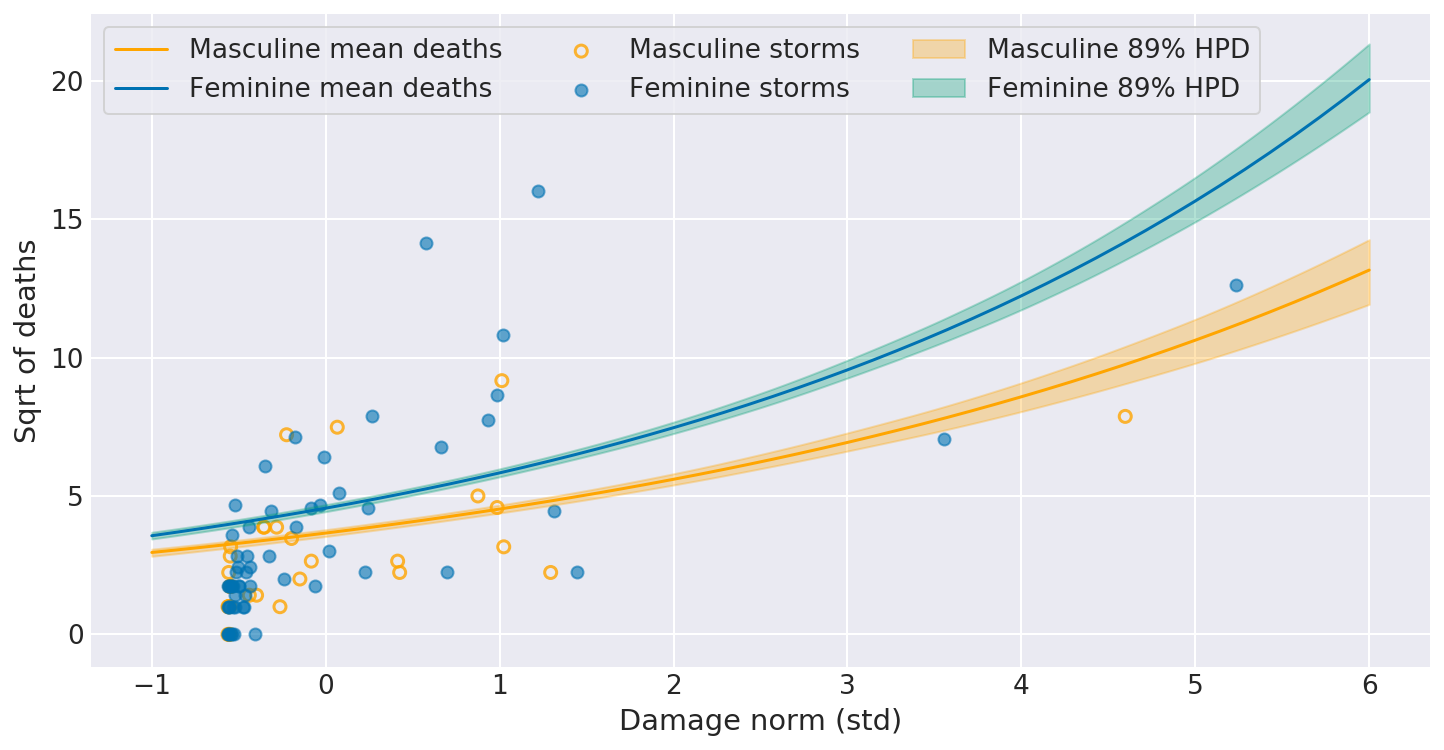

In [9]:
post_inter = pm.trace_to_dataframe(trace_damage_norm_inter)

# define values to compute OOS predictions over
damnorm_seq = np.linspace(-1, 6)

# lambda calcs for masculine names (i.e femininity = -1)
l_post_pred_m = []
for damnorm in damnorm_seq:
    l_post_pred_m.append(np.exp(post_inter['a'] - post_inter['bf'] + post_inter['bd']*damnorm - post_inter['bfd']*damnorm).values)
l_post_pred_m = np.asarray(l_post_pred_m).T

# lambda calcs for feminine names (i.e femininity = 1)
l_post_pred_f = []
for damnorm in damnorm_seq:
    l_post_pred_f.append(np.exp(post_inter['a'] + post_inter['bf'] + post_inter['bd']*damnorm + post_inter['bfd']*damnorm).values)
l_post_pred_f = np.asarray(l_post_pred_f).T
    
# plot
plt.figure(figsize=(12,6))
masc_storms = hurricanes[hurricanes.femininity_std < 0]
fem_storms = hurricanes[hurricanes.femininity_std >= 0]

plt.scatter(masc_storms.damage_norm_std, np.sqrt(masc_storms.deaths), label="Masculine storms", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)
plt.scatter(fem_storms.damage_norm_std, np.sqrt(fem_storms.deaths), label="Feminine storms", alpha=0.6)
az.plot_hpd(damnorm_seq, np.sqrt(l_post_pred_m), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "color": "orange", "label": "Masculine 89% HPD"})
az.plot_hpd(damnorm_seq, np.sqrt(l_post_pred_f), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "label": "Feminine 89% HPD"})
plt.plot(damnorm_seq, np.sqrt(l_post_pred_m.mean(axis=0)), color="orange", label="Masculine mean deaths")
plt.plot(damnorm_seq, np.sqrt(l_post_pred_f.mean(axis=0)), label="Feminine mean deaths")

plt.xlabel("Damage norm (std)")
plt.ylabel("Sqrt of deaths")
plt.legend(ncol=3, frameon=True);

Now we see the anticipated relationship: feminine storms are stronger at all damage values, and the difference from masculine storms increases with damage. But the effect is very small. Look at the coefficients to see why:

In [40]:
pm.summary(trace_damage_norm_inter, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.81,0.03,0.0,2.77,2.86,1448.84,1.0
bf,0.22,0.03,0.0,0.18,0.26,1710.39,1.0
bd,0.46,0.01,0.0,0.44,0.48,1552.68,1.0
bfd,0.03,0.01,0.0,0.01,0.05,1360.94,1.0


The interaction coefficient is quite small - reliably positive, but tiny. So it doesn’t make much difference, until storm damage grows massive.

In [45]:
az.compare({"m_damage_norm_inter": trace_damage_norm_inter, "m_damage_norm_nointer": trace_damage_norm_nointer, 
            "m_min_pressure_inter": trace_min_pressure_inter, "m_min_pressure_nointer": trace_min_pressure_nointer})

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/ana

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_damage_norm_nointer,3207.11,124.765,0,0.350886,789.534,0,1,deviance
m_damage_norm_inter,3228.89,147.027,21.7838,0.037351,792.495,28.5985,1,deviance
m_min_pressure_nointer,3475.22,209.378,268.11,0.611108,1110.78,816.385,1,deviance
m_min_pressure_inter,3574.04,259.486,366.933,0.000654568,1147.41,817.936,1,deviance


The models including damage_norm do better than those with min_pressure, so for a final task here (although we could have done much more), let’s consider a gamma-Poisson version of the damage model:

In [10]:
with pm.Model() as m_dm_gampois:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    bfd = pm.Normal('bfd', 0., .8)
    lam = pm.math.exp(a + bf*hurricanes.femininity_std + bd*hurricanes.damage_norm_std + bfd*hurricanes.damage_norm_std*hurricanes.femininity_std)
    
    scale = pm.Exponential("scale", 1.)
    
    deaths = pm.NegativeBinomial("deaths", mu=lam, alpha=scale, observed=hurricanes.deaths)

    trace_dm_gampois = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED, nuts_kwargs={"target_accept": .9})

post_dm_gampois = pm.trace_to_dataframe(trace_dm_gampois)
pm.summary(trace_dm_gampois, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale, bfd, bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 296.34draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.60,0.14,0.00,2.39,2.82,2363.58,1.0
bf,0.09,0.13,0.00,-0.12,0.28,2321.72,1.0
bd,1.21,0.23,0.01,0.83,1.53,1672.98,1.0
bfd,0.30,0.20,0.00,0.02,0.67,2208.49,1.0
scale,0.69,0.10,0.00,0.53,0.86,2125.69,1.0


This model finds a stronger relationship with damage and a stronger interaction, but both estimates are now much more variable. This is what we should expect from a gamma-Poisson model. The gamma-distributed rates allow for a wider range of parameter values to produce similar predictions. What do the predictions look like now?

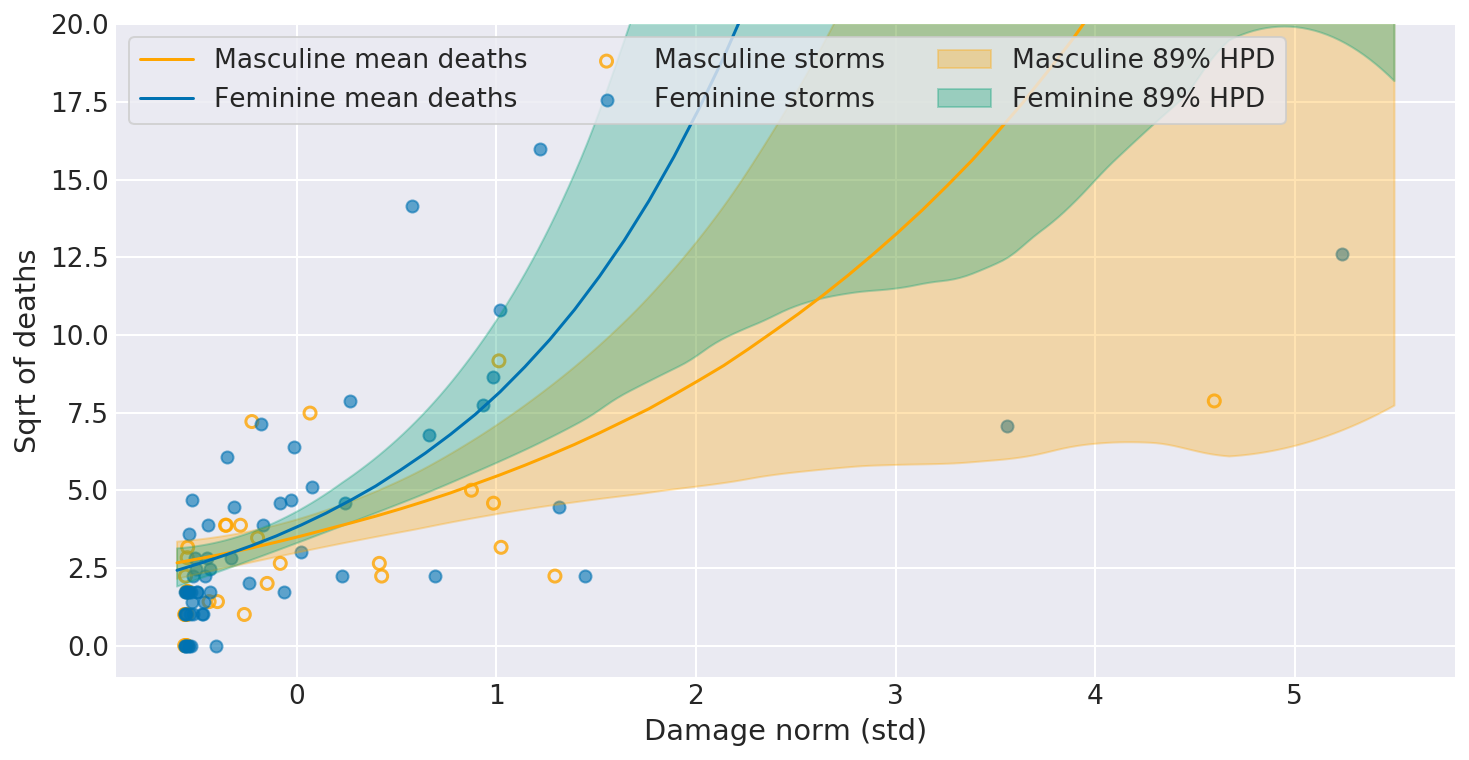

In [11]:
# define values to compute OOS predictions over
damnorm_seq = np.linspace(-0.6, 5.5)

# lambda calcs for masculine names (i.e femininity = -1)
l_post_pred_m = []
for damnorm in damnorm_seq:
    l_post_pred_m.append(np.exp(post_dm_gampois['a'] - post_dm_gampois['bf'] + post_dm_gampois['bd']*damnorm - post_dm_gampois['bfd']*damnorm).values)
l_post_pred_m = np.asarray(l_post_pred_m).T

# lambda calcs for feminine names (i.e femininity = 1)
l_post_pred_f = []
for damnorm in damnorm_seq:
    l_post_pred_f.append(np.exp(post_dm_gampois['a'] + post_dm_gampois['bf'] + post_dm_gampois['bd']*damnorm + post_dm_gampois['bfd']*damnorm).values)
l_post_pred_f = np.asarray(l_post_pred_f).T
    
# plot
plt.figure(figsize=(12,6))
masc_storms = hurricanes[hurricanes.femininity_std < 0]
fem_storms = hurricanes[hurricanes.femininity_std >= 0]

plt.scatter(masc_storms.damage_norm_std, np.sqrt(masc_storms.deaths), label="Masculine storms", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)
plt.scatter(fem_storms.damage_norm_std, np.sqrt(fem_storms.deaths), label="Feminine storms", alpha=0.6)
az.plot_hpd(damnorm_seq, np.sqrt(l_post_pred_m), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "color": "orange", "label": "Masculine 89% HPD"})
az.plot_hpd(damnorm_seq, np.sqrt(l_post_pred_f), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "label": "Feminine 89% HPD"})
plt.plot(damnorm_seq, np.sqrt(np.median(l_post_pred_m, axis=0)), color="orange", label="Masculine mean deaths")
plt.plot(damnorm_seq, np.sqrt(np.median(l_post_pred_f, axis=0)), label="Feminine mean deaths")

plt.ylim([-1, 20])
plt.xlabel("Damage norm (std)")
plt.ylabel("Sqrt of deaths")
plt.legend(ncol=3, frameon=True, loc="upper left");

This plot looks a little strange because of the overlapping prediction regions for masculine and feminine storms. In the R model, feminine storms are again more deadly at all damage amounts, and the difference grows with damage. But in the PyMC model, both kinds of storms are actually tied for damage values <= -0.2, and then feminine storms become more deadly, with the difference growing with damage. But in both models, note that now predictions are all over the place, especially for masculine storms. This is a result of allowing the gamma-distributed variation.

So what’s going on in these data? No one really knows. But I think that there just isn’t much statistical evidence for the interaction. It’s driven by few storms, and most of the variation in the data has little to do with damage or femininity of names. Given that this is an observational, rather than experimental, study, almost anything could be creating the correlation, weak as it is, between femininity and deaths. Why? Because there are many unmeasured confounds. So analyses like these are heavily dependent upon how plausible you find the hypothesis. I personally find it highly implausible that people refuse to evacuate because they imagine “Andrea” is not dangerous while “Andrew” is. If you’ve ever been in a hurricane evacuation, you might agree with me. But other people, including the authors of the study, apparently do find this idea plausible. Regardless, the data aren’t going to resolve the issue.

### 11H4.
*In the original hurricanes paper, storm damage (damage_norm) was used directly. This assumption implies that mortality increases exponentially with a linear increase in storm strength, because a Poisson regression uses a log link (hence an exponential inverse link). So it's worth exploring an alternative hypothesis: that the logarithm of storm strength is what matters. Explore this by using the logarithm of damage_norm as a predictor. Using the best model structure from the previous problem, compare a model that uses log(damage_norm) to a model that uses damage_norm directly. Compare their DIC/WAIC values as well as their implied predictions. What do you conclude?*

In [15]:
femininity_std = hurricanes.femininity_std
hurricanes["log_dam_std"] = stdz(np.log(hurricanes.damage_norm))
log_dam_std = hurricanes.log_dam_std

with pm.Model() as m_log_dam_inter:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    bfd = pm.Normal('bfd', 0., .8)
    lam = pm.math.exp(a + bf*femininity + bd*log_dam_std + bfd*femininity*log_dam_std)

    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_log_dam_inter = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_log_dam_nointer:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    lam = pm.math.exp(a + bf*femininity + bd*log_dam_std)
    
    deaths = pm.Poisson('deaths', mu=lam, observed=hurricanes.deaths)

    trace_log_dam_nointer = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

az.compare({"m_log_dam_inter": trace_log_dam_inter, "m_log_dam_nointer": trace_log_dam_nointer,
            "m_dam_inter": trace_damage_norm_inter, "m_dam_nointer": trace_damage_norm_nointer})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bfd, bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:16<00:00, 373.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:13<00:00, 454.77draws/s]
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indic

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_log_dam_inter,2090.95,104.732,0,0.568837,438.387,0,1,deviance
m_log_dam_nointer,2123.96,90.4832,33.0044,0.158285,447.797,48.7678,1,deviance
m_dam_nointer,3207.11,124.765,1116.16,0.272878,789.534,428.243,1,deviance
m_dama_inter,3228.89,147.027,1137.94,3.06422e-14,792.495,431.272,1,deviance


The log-damage models are kickin’ it! And the interaction model comes out ahead of the main effect model. Let’s look at its coefficients, before plotting some counterfactual predictions:

In [16]:
post_log_dam_inter = pm.trace_to_dataframe(trace_log_dam_inter)
pm.summary(trace_log_dam_inter, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.18,0.04,0.0,2.11,2.24,1108.55,1.0
bf,0.01,0.04,0.0,-0.06,0.08,1074.33,1.0
bd,1.51,0.04,0.0,1.45,1.57,1142.08,1.0
bfd,0.30,0.04,0.0,0.23,0.36,1111.07,1.0


The main effect of femininity now straddles zero, but the interaction is reliably positive. As always, some plotting is really needed to understand the implications:

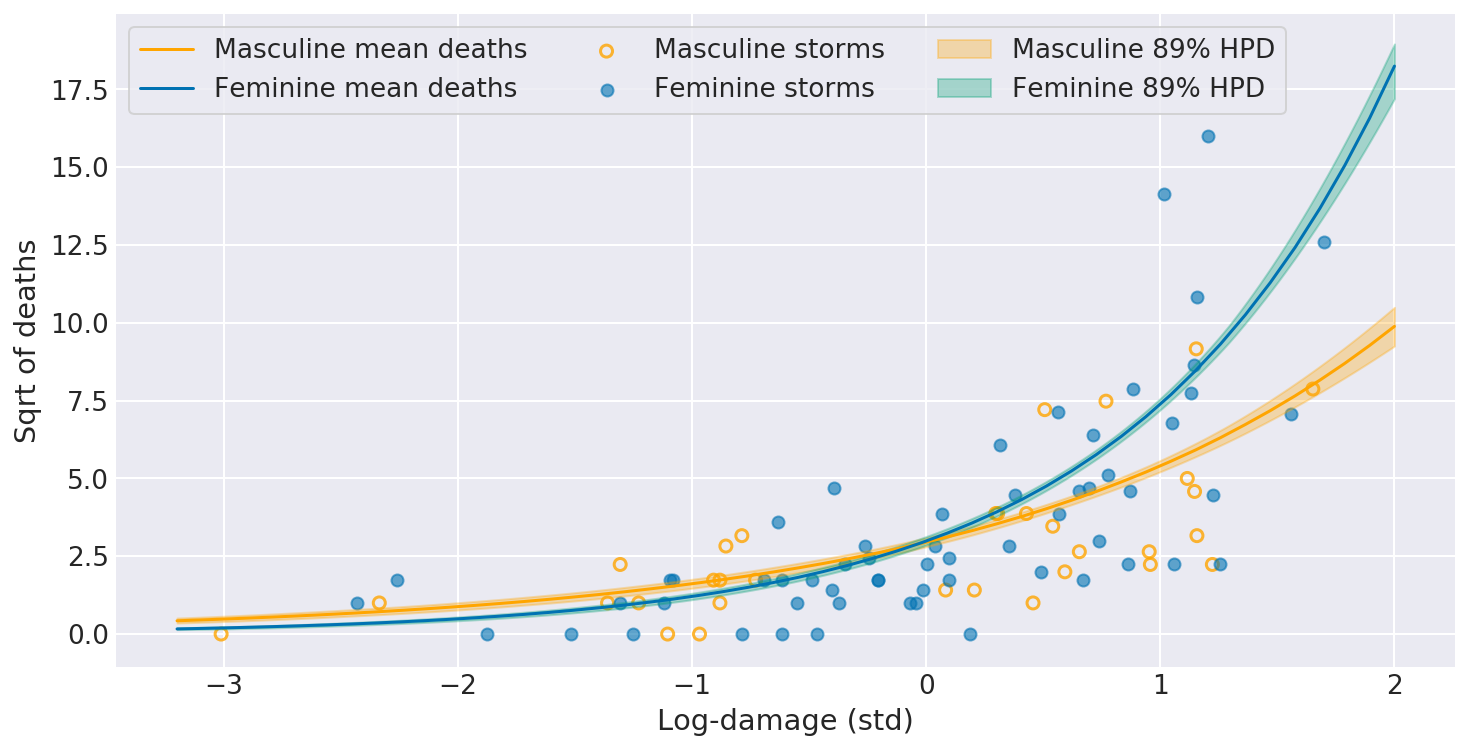

In [21]:
# define values to compute OOS predictions over
log_damnorm_seq = np.linspace(-3.2, 2)

# lambda calcs for masculine names (i.e femininity = -1)
l_post_pred_m = []
for log_damnorm in log_damnorm_seq:
    l_post_pred_m.append(np.exp(post_log_dam_inter['a']\
                                - post_log_dam_inter['bf']\
                                + post_log_dam_inter['bd']*log_damnorm\
                                - post_log_dam_inter['bfd']*log_damnorm).values)
l_post_pred_m = np.asarray(l_post_pred_m).T

# lambda calcs for feminine names (i.e femininity = 1)
l_post_pred_f = []
for log_damnorm in log_damnorm_seq:
    l_post_pred_f.append(np.exp(post_log_dam_inter['a']\
                                + post_log_dam_inter['bf']\
                                + post_log_dam_inter['bd']*log_damnorm\
                                + post_log_dam_inter['bfd']*log_damnorm).values)
l_post_pred_f = np.asarray(l_post_pred_f).T
    
# plot
plt.figure(figsize=(12,6))
masc_storms = hurricanes[hurricanes.femininity_std < 0]
fem_storms = hurricanes[hurricanes.femininity_std >= 0]

plt.scatter(masc_storms.log_dam_std, np.sqrt(masc_storms.deaths), label="Masculine storms", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)
plt.scatter(fem_storms.log_dam_std, np.sqrt(fem_storms.deaths), label="Feminine storms", alpha=0.6)
az.plot_hpd(log_damnorm_seq, np.sqrt(l_post_pred_m), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "color": "orange", "label": "Masculine 89% HPD"})
az.plot_hpd(log_damnorm_seq, np.sqrt(l_post_pred_f), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "label": "Feminine 89% HPD"})
plt.plot(log_damnorm_seq, np.sqrt(np.median(l_post_pred_m, axis=0)), color="orange", label="Masculine mean deaths")
plt.plot(log_damnorm_seq, np.sqrt(np.median(l_post_pred_f, axis=0)), label="Feminine mean deaths")

plt.xlabel("Log-damage (std)")
plt.ylabel("Sqrt of deaths")
plt.legend(ncol=3, frameon=True);

In this perspective, it’s only at the highest damage levels that there is a difference between masculine and feminine storms. The feminine storms did do more damage, on average. But there’s not much difference for the majority of storms.

You might wonder what the gamma-Poisson interaction model is like. So let’s try it:

In [22]:
with pm.Model() as m_log_dam_inter_gampois:
    a = pm.Normal('a', 0., 4.5)
    bf = pm.Normal('bf', 0., .8)
    bd = pm.Normal('bd', 0., .8)
    bfd = pm.Normal('bfd', 0., .8)
    lam = pm.math.exp(a + bf*femininity + bd*log_dam_std + bfd*femininity*log_dam_std)
    
    scale = pm.Exponential("scale", 1.)
    
    deaths = pm.NegativeBinomial("deaths", mu=lam, alpha=scale, observed=hurricanes.deaths)

    trace_log_dam_inter_gampois = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_log_dam_inter_gampois = pm.trace_to_dataframe(trace_log_dam_inter_gampois)
pm.summary(trace_log_dam_inter_gampois, alpha=0.11).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale, bfd, bd, bf, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 298.62draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,2.26,0.12,0.0,2.08,2.45,2082.01,1.0
bf,0.04,0.11,0.0,-0.13,0.23,1917.43,1.0
bd,1.35,0.13,0.0,1.15,1.55,2650.63,1.0
bfd,0.16,0.12,0.0,-0.02,0.37,2571.07,1.0
scale,1.05,0.17,0.0,0.74,1.29,2013.12,1.0


As expected, the standard deviations of the coefficients have all increased, for the usual reason: allowing gamma-distributed heterogeneity makes many more parameter values plausible. Now what do the predictions look like?

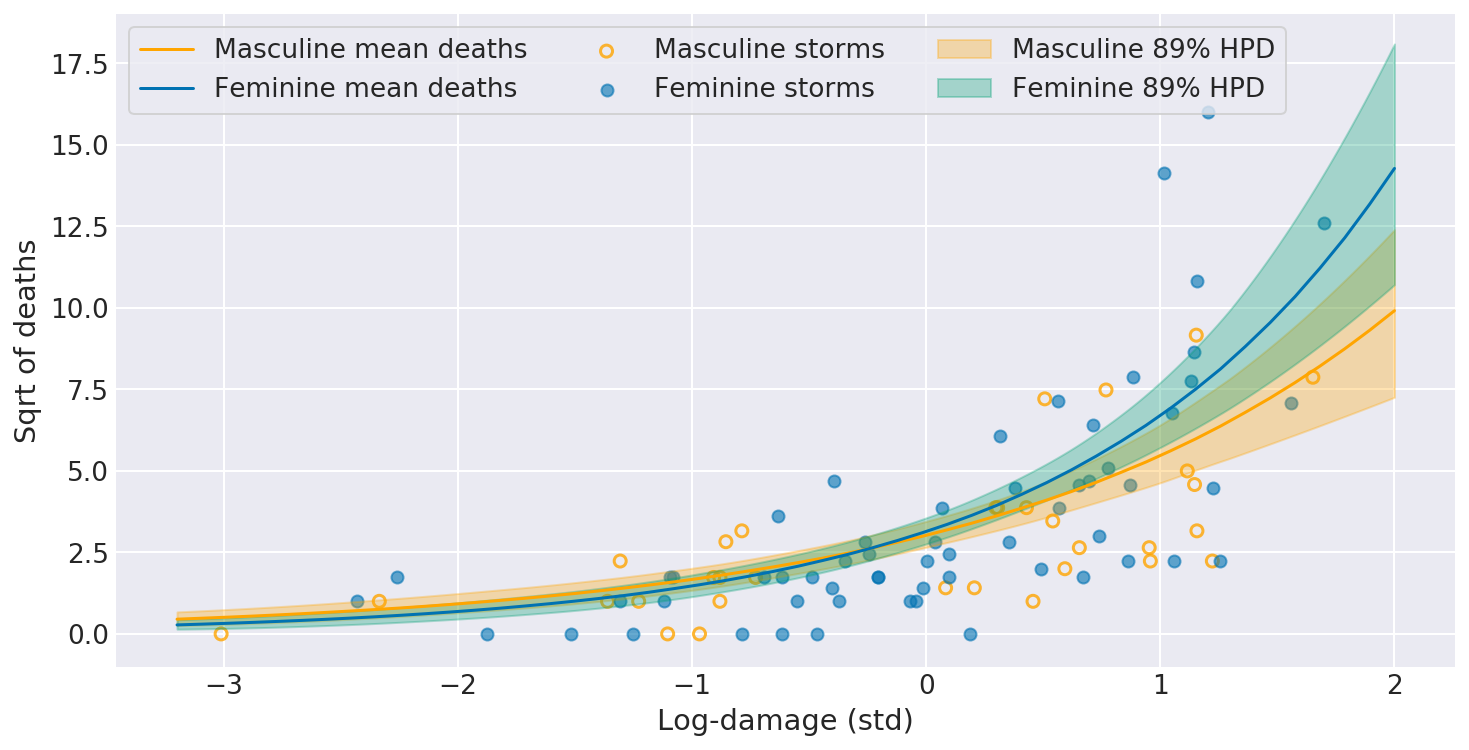

In [23]:
# lambda calcs for masculine names (i.e femininity = -1)
l_post_pred_m = []
for log_damnorm in log_damnorm_seq:
    l_post_pred_m.append(np.exp(post_log_dam_inter_gampois['a']\
                                - post_log_dam_inter_gampois['bf']\
                                + post_log_dam_inter_gampois['bd']*log_damnorm\
                                - post_log_dam_inter_gampois['bfd']*log_damnorm).values)
l_post_pred_m = np.asarray(l_post_pred_m).T

# lambda calcs for feminine names (i.e femininity = 1)
l_post_pred_f = []
for log_damnorm in log_damnorm_seq:
    l_post_pred_f.append(np.exp(post_log_dam_inter_gampois['a']\
                                + post_log_dam_inter_gampois['bf']\
                                + post_log_dam_inter_gampois['bd']*log_damnorm\
                                + post_log_dam_inter_gampois['bfd']*log_damnorm).values)
l_post_pred_f = np.asarray(l_post_pred_f).T
    
# plot
plt.figure(figsize=(12,6))
masc_storms = hurricanes[hurricanes.femininity_std < 0]
fem_storms = hurricanes[hurricanes.femininity_std >= 0]

plt.scatter(masc_storms.log_dam_std, np.sqrt(masc_storms.deaths), label="Masculine storms", alpha=0.8, 
            facecolors="none", edgecolors="orange", linewidths=1.5)
plt.scatter(fem_storms.log_dam_std, np.sqrt(fem_storms.deaths), label="Feminine storms", alpha=0.6)
az.plot_hpd(log_damnorm_seq, np.sqrt(l_post_pred_m), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "color": "orange", "label": "Masculine 89% HPD"})
az.plot_hpd(log_damnorm_seq, np.sqrt(l_post_pred_f), credible_interval=0.89,
            fill_kwargs={"alpha": 0.3, "label": "Feminine 89% HPD"})
plt.plot(log_damnorm_seq, np.sqrt(np.median(l_post_pred_m, axis=0)), color="orange", label="Masculine mean deaths")
plt.plot(log_damnorm_seq, np.sqrt(np.median(l_post_pred_f, axis=0)), label="Feminine mean deaths")

plt.xlabel("Log-damage (std)")
plt.ylabel("Sqrt of deaths")
plt.legend(ncol=3, frameon=True);

Those four feminine super-storms on the righthand side are still pulling the feminine trend upwards, but the gamma-distributed variation accounts for some of their distance from the mean, allowing the median prediction (the solid blue trend) to rest lower than in the pure (homogenous) Poisson model.

### 11H5.
*One hypothesis from developmental psychology, usually attributed to Carol Gilligan, proposes that women and men have different average tendencies in moral reasoning. Like most hypotheses in social psychology, it is merely descriptive. The notion is that women are more concerned with care (avoiding harm), while men are more concerned with justice and rights. Culture-bound nonsense? Yes. Descriptively accurate? Maybe.*

*Evaluate this hypothesis using the Trolley data, supposing that contact provides a proxy for physical harm. Are women more or less bothered by contact than are men, in these data? Figure out the model(s) that is needed to address this question.*

In [3]:
trolley_df = pd.read_csv('../Data/Trolley.csv', sep=';')
trolley_df.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


To see whether females in these data are more bothered (rate as less permissible) by scenarios involving the contact principle (contact==1), we need an interaction effect. The reason is that just including a main effect of male only addresses whether men are likely to rate any scenario as more or less permissible. It doesn’t address a gender difference in any particular principle. So we need an interaction male x contact, at least. We don't have to, but we're going to make a new variable, female, so that we can focus on females, like the question asks:

In [4]:
with pm.Model() as m11_1:
    a = pm.Normal(
        'a', 0., 10.,
        transform=pm.distributions.transforms.ordered,
        shape=6, testval=np.arange(6) - 2.5)
    
    resp_obs = pm.OrderedLogistic(
        'resp_obs', 0., a,
        observed=trolley_df.response - 1
    )
    
    trace_11_1 = pm.sample(1000, tune=1000, cores=2)

/anaconda/envs/fund/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/anaconda/envs/fund/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda/envs/fund/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multi

In [7]:
trolley_df["female"] = 1 - trolley_df.male

with pm.Model() as m_trolley:
    a = pm.Normal('a', 0., 10., transform=pm.distributions.transforms.ordered, shape=6, testval=np.arange(6) - 2.5)
    ba = pm.Normal('ba', 0., 10.)
    bi = pm.Normal('bi', 0., 10.)
    bc = pm.Normal('bc', 0., 10.)
    bai = pm.Normal('bai', 0., 10.)
    bci = pm.Normal('bci', 0., 10.)
    bf = pm.Normal('bf', 0., 10.)
    bcf = pm.Normal('bcf', 0., 10.)
    
    #action = pm.Data("action", trolley_df.action)
    #intention = pm.Data("intention", trolley_df.intention)
    #contact = pm.Data("contact", trolley_df.contact)
    #female = pm.Data("female", trolley_df.female)
    #phi = ba*action + bi*intention + bc*contact + bai*action*intention + bci*contact*intention + bf*female + bcf*contact*female
    phi = ba*trolley_df.action + bi*trolley_df.intention + bc*trolley_df.contact + bai*trolley_df.action*trolley_df.intention\
        + bci*trolley_df.contact*trolley_df.intention + bf*trolley_df.female + bcf*trolley_df.contact*trolley_df.female

    resp_obs = pm.OrderedLogistic('resp_obs', phi, a, observed=trolley_df.response - 1) # switching responses to 0-index
    
    trace_trolley = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

post_trolley = pm.trace_to_dataframe(trace_trolley)
pm.summary(trace_trolley, alpha=0.11).round(2)

/anaconda/envs/fund/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/anaconda/envs/fund/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bcf, bf, bci, bai, bc, bi, ba, a]
Sampling 2 chains: 100%|██████████| 6000/6000 [1

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
ba,-0.47,0.05,0.0,-0.55,-0.39,1425.42,1.0
bi,-0.28,0.06,0.0,-0.37,-0.20,1305.42,1.0
bc,-0.43,0.08,0.0,-0.56,-0.31,1492.15,1.0
bai,-0.46,0.08,0.0,-0.58,-0.33,1437.46,1.0
bci,-1.30,0.10,0.0,-1.46,-1.15,1494.88,1.0
bf,-0.62,0.04,0.0,-0.68,-0.55,2141.35,1.0
bcf,0.21,0.09,0.0,0.08,0.37,2022.74,1.0
a__0,-2.95,0.06,0.0,-3.04,-2.86,1397.14,1.0
a__1,-2.25,0.05,0.0,-2.33,-2.17,1402.28,1.0
a__2,-1.65,0.05,0.0,-1.72,-1.57,1386.62,1.0


Inspect the estimates for $b_{f}$ (the main effect of being female on cumulative log-odds) and $b_{fc}$ (the interaction effect of being both female and in a contact scenario). The main effect is negative, -0.62, and the interaction is positive, 0.21. It will be easier to make the comparison between females and males if we compute expected log-odds for both females and males, both with and without contact treatment.

### 11H6.
*The data in fish.csv are records of visits to a national park. The question of interest is how many fishs an average visitor takes per hour, when fishing. The problem is that not everyone tried to fish, so the fish_caught numbers are zero-inflated. As with the monks example in the chapter, there is a process that determines who is fishing (working) and another process that determines fish per hour (manuscripts per day), conditional on fishing (working). We want to model both. Otherwise we'll end up with an underestimate of rate of fish extraction from the park.*

*You will model these data using zero-inflated Poisson GLMs. Predict fish_caught as a function of any of the other variables you think are relevant. One thing you must do however is use a proper Poisson offset/exposure in the Poisson portion of the zero-inflated model. Then use the hours variable to construct the offset. This will adjust the model for the differing amount of time individuals spent in the park.*

In [2]:
fish = pd.read_csv("../Data/fish.csv", sep=";")
fish.head()

,fish_caught,livebait,camper,persons,child,hours
0,0,0,0,1,0,21.124
1,0,1,1,1,0,5.732
2,0,1,0,1,0,1.323
3,0,1,1,2,1,0.548
4,1,1,0,1,0,1.695


In [4]:
with pm.Model() as m_baseline:
    ap = pm.Normal('ap', 0., 10.)
    al = pm.Normal('al', 0., 10.)
    
    loghours = pm.Data("loghours", np.log(fish.hours.values)) # Poisson offset
    p = pm.math.invlogit(ap)
    lam = pm.math.exp(loghours + al)
    
    fish_caught = pm.ZeroInflatedPoisson('fish_caught', 1. - p, lam, observed=fish.fish_caught)
    
    trace_baseline = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)
    
with pm.Model() as m_fish:
    ap = pm.Normal('ap', 0., 10.)
    bp0 = pm.Normal('bp0', 0., 1.)
    bc0 = pm.Normal('bc0', 0., 1.)
    
    al = pm.Normal('al', 0., 10.)
    bp = pm.Normal('bp', 0., 1.)
    bc = pm.Normal('bc', 0., 1.)
    
    loghours = pm.Data("loghours", np.log(fish.hours.values)) # Poisson offset
    persons = pm.Data("persons", fish.persons.values)
    child = pm.Data("child", fish.child.values)
    p = pm.math.invlogit(ap + bp0*persons + bc0*child)
    lam = pm.math.exp(loghours + al + bp*persons + bc*child)
    
    fish_caught = pm.ZeroInflatedPoisson('fish_caught', 1. - p, lam, observed=fish.fish_caught)
    
    trace_fish = pm.sample(1000, tune=2000, cores=2, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [al, ap]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:09<00:00, 608.36draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [bc, bp, al, bc0, bp0, ap]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:52<00:00, 113.21draws/s]


Here’s an example of an intercept-only model, for comparison with a model using a subset of the predictors. In m_fish, there are two key things to note. First, the parameters are different in the two linear models. No parameters are shared among them. This allows the same predictors to potentially influence each part of the process in different ways - we could even have used different predictors in each of the two linear models. Second, the offset loghours is added onto the linear model for lam, the mean of the Poisson process producing fish. This corrects for the fact that some visitors stayed longer, so had more opportunity to catch fish.

In [5]:
az.compare({"m_fish": trace_fish, "m_baseline": trace_baseline})

/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.append(np.stack(log_like))
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/stats/stats.py:1014: UserWarning: For one or more samples the posterior variance of the log predictive
        densities exceeds 0.4. This could be indication of WAIC starting to fail see
        http://arxiv.org/abs/1507.04544 for details
        
  """
/anaconda/envs/stat-rethink-pymc3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:56: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  chain_likelihoods.appe

,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_fish,2179.97,90.1809,0,0.751002,393.998,0,1,deviance
m_baseline,2562.87,42.7484,382.897,0.248998,467.367,210.668,1,deviance


The second model seems better than the intercept-only model, so let's inspect its parameter estimates:

In [6]:
pm.summary(trace_fish, alpha=0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
ap,0.80,0.57,0.01,-0.01,1.77,1211.18,1.01
bp0,-1.03,0.28,0.01,-1.46,-0.58,1153.80,1.00
bc0,1.04,0.55,0.01,0.28,1.96,1535.22,1.00
al,-2.30,0.15,0.00,-2.53,-2.06,1507.19,1.00
bp,0.67,0.04,0.00,0.61,0.74,1498.42,1.00
bc,0.56,0.09,0.00,0.43,0.72,1597.53,1.00


Recall that $a_{p}$, $b_{p0}$ and $b_{c0}$ are on the log-odds scale, while $a_{l}$, $b_{p}$ and $b_{c}$ are on the log scale. When generating predictions, we need to consider each component of the process separately: the $p$s are the probabilities of not fishing for each sample and the $lam$s are the expected numbers of fish caught (conditional on fishing) for each sample. In other words, the $p$ values provide predictions for excess zeros, and the $lam$ values for the Poisson process (which can also produce zeros). For example, if $p = 0.5$ and $lam = 1$ (fixed right now for ease of understanding), then the implied predictive distribution is:

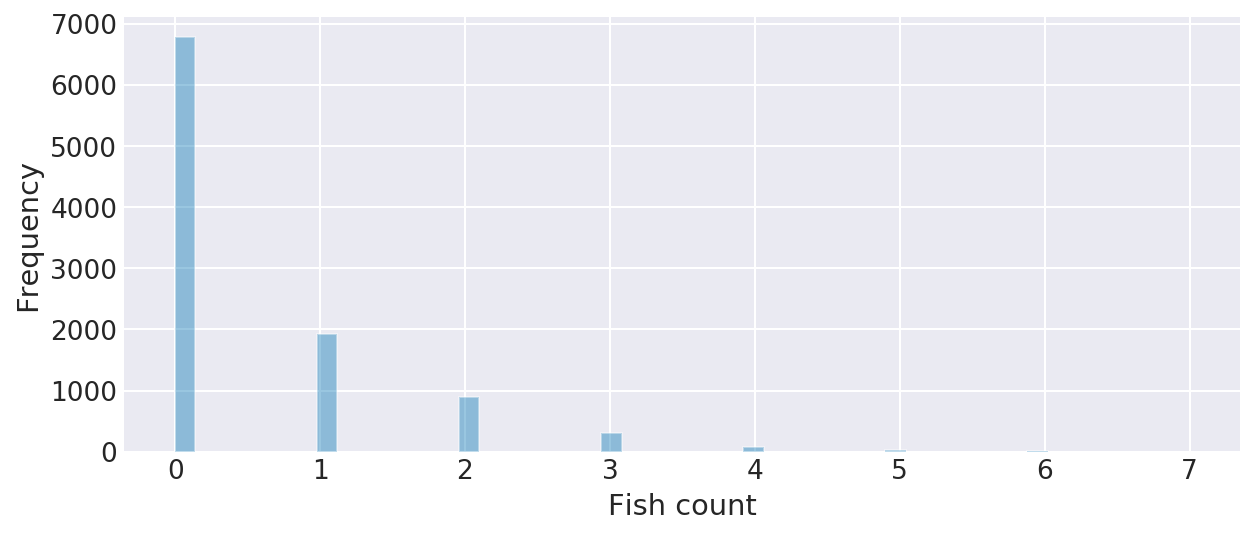

In [7]:
zeros = np.random.binomial(1, 0.5, 10000)
obs_fish = (1 - zeros) * np.random.poisson(1., 10000)

plt.figure(figsize=(10,4))
sns.distplot(obs_fish, kde=False)
plt.xlabel("Fish count")
plt.ylabel("Frequency");

Now luckily sample_posterior_predictive understands all of this, because it knows the model already. So you can just:

In [8]:
fish_sim = pm.sample_posterior_predictive(trace_fish, model=m_fish, random_seed=RANDOM_SEED)['fish_caught']

100%|██████████| 2000/2000 [00:06<00:00, 320.07it/s]


And these simulations integrate over the posterior uncertainty, so there is one simulation for each sample.

You could go on to summarize and plot these simulations. But what we actually want is counterfactual posterior predictions. So let’s assume for example a party of 1 person spending 1 hour in the park. Let’s do that now:

In [12]:
post_fish = pm.trace_to_dataframe(trace_fish)

p_ppc = sp.special.expit(post_fish["ap"] + post_fish["bp0"]*1 + post_fish["bc0"]*0)
lam_ppc = np.exp(np.log(1) + post_fish["al"] + post_fish["bp"]*1 + post_fish["bc"]*0)

print(f"Mean number of fish caught: {((1-p_ppc) * lam_ppc).mean()}")
print(f"89% HPD of number of fish caught: {az.hpd((1-p_ppc) * lam_ppc, credible_interval=0.89)}")

Mean number of fish caught: 0.10897557949140907
89% HPD of number of fish caught: [0.08020317 0.13637607]


In [17]:
# JUST FOR PULL REQUEST: shouldn't it give same results as the previous cell?
with m_fish:
    pm.set_data({"loghours": [np.log(1)], "persons": [1], "child": [0]})
    fish_ppc = pm.sample_posterior_predictive(trace_fish, random_seed=RANDOM_SEED)['fish_caught']

print(f"Mean number of fish caught: {fish_ppc.mean()}")
print(f"89% HPD of number of fish caught: {az.hpd(fish_ppc.mean(axis=0), credible_interval=0.89)}")

100%|██████████| 2000/2000 [00:06<00:00, 324.91it/s]

Mean number of fish caught: 0.109254
89% HPD of number of fish caught: [0.098 0.121]


What this means is that one person is expected to extract on average 0.11 fish per hour, with the interval shown. This estimate allows for the zero-inflation, so it accounts for the probability that the person is not fishing at all, depressing the expected value.